# Assignment 2 ― Classification

## 0. Introduction

In this second assigment, we will explore another cornerstone of machine learning: supervised classification. We will be specifically classifying IMDB movie reviews by their positive (1) or negative (-1) score. To do this, we will first pre-process the raw data by cleaning and turning each review into a vector. Then, we will explore and fine-tune our use of the following learning algorithms for classification: naive Bayes classifiers, support vector machines, and random forests. 

* [Question 1.1](#scrollTo=m0QxxH3KngAg)
* [Question 2.1](#scrollTo=6VWSBN37uXod)
* [Question 2.2](#scrollTo=CuW0ahvaJtOt)
* [Question 2.3](#scrollTo=co54Ubd5QJDN)
* [Question 3.1](#scrollTo=fN-dse1NBQnk)
* [Question 3.2](#scrollTo=wfCjr-JrEJya)
* [Question 3.3](#scrollTo=l1iGVZtkE5fF)
* [Question 4.1](#scrollTo=YKLBuWjmAKoJ)
* [Question 5.1](#scrollTo=Myn-42J9ACsH)
* [Question 5.2](#scrollTo=1LAqa9be_3vR)
* [Question 6.1](#scrollTo=C144CYOeYPca) [optional]
* [Question 6.2](#scrollTo=rnIbpGe-Z52z) [optional] 
* [Question 6.3](#scrollTo=W6CdJGpjcK2r) [optional]



$% latex commands for later use$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\B}{\mathbb{B}}$
$\newcommand{\argmax}{\operatorname*{arg\ max}}$
$\newcommand{\given}{\; \vert \;}$



## 1. Importing Libraries and Data

For this assignment, we will be using a dataset of IMDB reviews. The data consists of a csv file where the first column is a string containing a user review and the second column specifies whether the review was positve (1) or negative (-1). First, we will import any libraries that we might use.

**Note:** You may use any library you would like unless specified otherwise. 

### Question 1.1 Importing Libraries

Keep on adding in the section below any modules you use as you are completing the assignment.

In [7]:
import csv
import random
from datetime import datetime
import re
import numpy as np
import operator
import heapq 
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

Let's download the dataset:

In [8]:
!wget https://raw.githubusercontent.com/McGillAISociety/BootcampAssignmentDatasets/master/data/assignment2/train_reviews.csv

--2021-03-03 14:59:46--  https://raw.githubusercontent.com/McGillAISociety/BootcampAssignmentDatasets/master/data/assignment2/train_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33333854 (32M) [text/plain]
Saving to: ‘train_reviews.csv’

train_reviews.csv   100%[===================>]  31.79M   139MB/s    in 0.2s    

2021-03-03 14:59:47 (139 MB/s) - ‘train_reviews.csv’ saved [33333854/33333854]



And create a function to print a review:

In [9]:
def print_review(review, score):
  print('--------------- Review with score of {} ---------------'.format(score))
  print(review)
  print('------------------------------------------------------')
  print()

Let's load the data and see what the first 10 reviews look like:


In [10]:
with open('train_reviews.csv') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  # skip column names
  data = list(csv_reader)

for review, score in random.sample(data, 10):
  print_review(review,score)

--------------- Review with score of 1 ---------------
Great movie, enough laughs and action for any audience.<br /><br />Since the last person who posted on this movie took it upon themselves to call Woody Allen incestuous and not comment on the film, here I am.<br /><br />The film follows an unlikely duo, Johansson and Allen, as they follow a tip given to them by the ghost of a recently deceased English reporter. Their search takes them into the home of the killer, and eventually to a somewhat tragic end. But don't let the plot fool you, the film truly is hilarious and the acting is superb.<br /><br />It seems that as directors reach a certain age they really get things right. Clint Eastwood, Allen and Pollack all seem to making some of the most imaginative work of their respective careers. Also, from watching the movie in a pact theater, you can just tell that people really love Woody Allen and are ready for him to really make a comeback. The second he walked on screen audience lit 

## 2. Preprocessing
 We will be converting our data into a binary bag-of-words representation (Google "binary bag-of-words"). To do this, we will perform two steps beforehand.

### Question 2.1 Cleaning the train data
Create a function called `clean`, which takes a string and then:

 1. lower-cases all words 
 2. only keeps letters and spaces
 

 We also need to get rid of [HTML tags](https://www.javatpoint.com/html-tags) as they do not hold valuable information for classifying the review. A quick Google search on removing HTML tags with `regular expressions` will show you how to do this! 
  
  For example, the following review...
  
  >`This was the WORST movie I have EVER SEEN!! <br/>`
  
  ...will be cleaned to become:
  
  >`this was the worst movie i have ever seen`
  
   Of course, you could do more pre-processing steps if you would like, such as lemmatization, stemming, etc... but TOTALLY OPTIONAL! 

In [11]:
def clean(review):
  return re.sub(r'[^a-zA-Z ]+','',re.sub(re.compile('<.*?>'),'',review).lower())
 

Test your function with this example string

In [12]:
print(clean("This was the WORST movie I have EVER SEEN!! <br/> "))

this was the worst movie i have ever seen  


Now, we'll use the function to clean the whole dataset. We'll also turn the scores from strings to integers while we're at it.

In [14]:
X_train = []
y_train = []
for review, score in data:
  X_train.append(clean(review))
  y_train.append(int(score))

### Question 2.2 Picking features

We now need to turn each review into vectors. We will pick the 10,000 most recurring words in the train set as features

Using those 10,000 features, create a function called `vectorize` which will take a string as an input, and convert it to a vector using the binary bag of words representation.

For example, the string `"This movie made me cry"` will become a vector of size 10,000 with 5 elements being 1 (assuming each word is part of the 10,000 most common) and 9995 being 0, that it, is i will look something like

 > `[0, 0, ..., 0, 1, 0, ..., 0, 1, 0..., 0, 1, 0, ..., 0, 1, 0 ..., 0, 1, 0, ..., 0, 0]`
 
 In order to accomplish this task, you will
 
 1. write a `get_vocab` function which takes as an argument a list of (cleaned) reviews and the vocabulary size and outputs the list of size `vocab_size` containing the most common words.
 2. write a `vectorize` function which takes as an argument a review and the vocabulary and turns the review into its binary bag of words representation.
 3. use the `vectorize` function to create a new variable called `X_train_vect` which will contain the bag-of-words representation of each data point contained in the `X_train` variable rather than its string representation.

**Warning**: the last step may take up to 15 minutes depending on your implementation. Despite the execution speed not being evaluated in this assignment, do try your best to have fast and efficient code!

In [15]:
def get_vocab(reviews, vocab_size): 
  word_frequncey ={}
  for s in reviews:
    words = clean(s).split()
    for w in words:
      if w in word_frequncey.keys():
        word_frequncey[w] += 1
      else: 
        word_frequncey[w] = 1
      
  return heapq.nlargest(vocab_size, word_frequncey, key=word_frequncey.get)
  


Test your function with the following code. The `vocabulary` variable should have a length of 10,000 and the most common words should be "the", "and", "a", etc.

In [16]:
num_features = 10000
vocabulary = get_vocab(X_train, num_features)
print(len(vocabulary))
print(vocabulary)

10000
['the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'who', 'from', 'like', 'so', 'her', 'or', 'just', 'about', 'has', 'out', 'if', 'some', 'what', 'there', 'good', 'more', 'very', 'when', 'she', 'even', 'up', 'no', 'would', 'my', 'which', 'time', 'only', 'really', 'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'been', 'get', 'well', 'will', 'into', 'because', 'people', 'other', 'bad', 'do', 'also', 'great', 'how', 'first', 'most', 'him', 'dont', 'made', 'movies', 'then', 'films', 'make', 'could', 'way', 'them', 'any', 'too', 'after', 'characters', 'think', 'watch', 'two', 'many', 'being', 'seen', 'character', 'never', 'little', 'acting', 'plot', 'where', 'best', 'love', 'did', 'know', 'life', 'show', 'does', 'ever', 'your', 'better', 'over', 'still', 'off', 'end', 'these', 'say', 'ma

In [17]:
def vectorize(review_string, vocab):
  arr = np.zeros(shape = (len(vocab),))
  words = review_string.split();
  for w in words:
    try:
      arr[vocab.index(w)] = 1
    except ValueError:
      continue
  #for i, w_i in enumerate(vocab):
  #  if w_i in review_string.split():
  #    arr[i] = 1
  return arr

Test your function with the following input. The vector should have four "1"s.

In [18]:
vector = vectorize("the and a of zyxw", vocabulary)
print(vector)
print(sum(vector))

[1. 1. 1. ... 0. 0. 0.]
4.0


Now, vectorize the whole dataset.

In [19]:
print(datetime.now().strftime("%H:%M:%S.%f"))
X_train_vect = []
for x in X_train:
  X_train_vect.append(vectorize(x, vocabulary))

print(datetime.now().strftime("%H:%M:%S.%f"))

15:00:44.572298
15:03:31.433900


In [20]:
for i in range(5):
  print_review(X_train_vect[i], y_train[i])

--------------- Review with score of -1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of 1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of -1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of -1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of 1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------



For convenience, we will write a function called `preprocess_sample_point` which takes as input a single raw review and ouputs its binary bag-of-words representation.

In [21]:
def preprocess_sample_point(review, vocab):
  return vectorize(clean(review), vocab)

In [22]:
vectorized_review = preprocess_sample_point(
    'The movie was not bad, it was really good!', vocabulary)
print(sum(vectorized_review))
print(vectorized_review)

8.0
[1. 0. 0. ... 0. 0. 0.]


### Question 2.3 Preparing the test set

Now that we have defined a cleaning function and extracted the features from the train set, we are ready to preprocess the test set. Implement the `preprocess` function below such that it:

1. Loads the raw data from a csv file 
2. Cleans and vectorizes the reviews
3. Converts the scores to `int`
4. Returns the data into a  `(X_test, y_test)` tuple

In [23]:
def preprocess(csv_filename, vocab):
  with open(csv_filename) as csv_file:
    csv_reader = csv.reader(csv_file)
    colnames = next(csv_reader)  # skip column names
    data = list(csv_reader)

  #X_test = [preprocess_sample_point(review, vocabulary) for review, score in data]
  #y_test = [int(score) for review, score in data]
  X_test = []
  y_test = []
  for review, score in data:
    X_test.append(preprocess_sample_point(review, vocabulary))
    y_test.append(int(score))

  return (X_test,y_test)

In [24]:
!wget https://raw.githubusercontent.com/McGillAISociety/BootcampAssignmentDatasets/master/data/assignment2/test_reviews.csv

--2021-03-03 15:03:31--  https://raw.githubusercontent.com/McGillAISociety/BootcampAssignmentDatasets/master/data/assignment2/test_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32551850 (31M) [text/plain]
Saving to: ‘test_reviews.csv’

test_reviews.csv    100%[===================>]  31.04M  57.0MB/s    in 0.5s    

2021-03-03 15:03:33 (57.0 MB/s) - ‘test_reviews.csv’ saved [32551850/32551850]



In [25]:
print(datetime.now().strftime("%H:%M:%S.%f"))
X_test, y_test = preprocess('test_reviews.csv', vocabulary)
print(datetime.now().strftime("%H:%M:%S.%f"))

15:03:33.169546
15:06:22.540899


In [26]:
for i in range(5):
  print_review(X_test[i], y_test[i])

--------------- Review with score of -1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of -1 ---------------
[1. 0. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of 1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of -1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------

--------------- Review with score of 1 ---------------
[1. 1. 1. ... 0. 0. 0.]
------------------------------------------------------



## 3. Naive Bayes

Later in this assignment, we will use pre-existing implementations of two types of models: random forests and support vector machines. However, we will start first by implementing from scratch a third type of classifier: naive Bayes classifers. 

Naive Bayes classifiers are part of a larger family of classifiers which are called 'probabilistic classifiers': not only do they try to predict classes given features, but they also estimate probability distributions over a set of classes.

First, let's will go over some definitions:

**Definition:** A *prior probability* is the likelihood of an event given no further assumptions. For instance, the probability that it's raining is relatively low.

**Definiton:** A *posterior probability* or *conditional probability* is the likelihood of an event given that some other event has occurred. For instance, the probability that it's raining given that there are clouds is higher than if we don't make that assumption.

Now we will go over some motivation:

For the purpose of argument, imagine we had access to the probability distribution $\Pr$. That is, we know how likely features and classes are. For example, $\Pr(x_1 = 1)$ is the probability that the most common word, i.e. "the" (represented by the feature $x_1$), is in a random movie review. Presumably, this probability is relatively high. As a second example, $\Pr(y = 1)$ is the probability that a random movie review is 'good'. 

Since we hypothetically have access to the whole probability distribution, we also know conditional probabilities. For instance, we would know $\Pr(y = -1 \; \vert \; x_1 = 0)$, which is the probability that a random review is 'bad', given that it does **not** contain the word "the".

Given a probability distribution, we can find an optimal classifier which simply picks the class which maximizes the probability that we will see the chosen class given the observed features. In other words our classifier $f: \B^n \to \B$ is given by:

$$ f(x_1, \ldots, x_n) = \argmax_{c \in \B} \Pr(y = c \given x_1, \ldots, x_n ).$$

Where $\argmax$ returns the element $c$ in $\B$ which maximizes the right-hand side expression, and $\B$ is the set with two elements: $\{-1, 1\}$. For example, we have:
$$ \argmax_{x \in \R} (x - x^2) = \frac 1 2, $$
since $\frac 1 2$ maximizes the expression $x - x^2$.

It would be great if we had access to the probability distribution $\Pr$, but unfortunately we don't in almost every case. This means we wish to try to estimate it given some samples, i.e. the training data.

However, we run into another issue: estimating the probability distribution is computionally expensive. Therefore, we assume that the different features are independent from one another. This is called the *naive conditional independence assumption*. In other words, we assume that

$$ \forall i \in \{1, \ldots, n\} : \Pr (x_i \given y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n) = \Pr(x_i \given y).$$

Using Bayes' Theorem, we can simplify the conditional independence assumption to:

$$\Pr(y \given x_1, \ldots, x_n) = \frac{\Pr(y) \prod_{i=1}^n \Pr(x_i \given y)}{\Pr(x_1, \ldots, x_n)}.$$

However, we can observe that the denominator is constant for a given input, so it's not actually necesarry to estimate it if all we want is to find the class with the maximum posterior probability. In other words,

$$ \Pr(y \given x_1, \ldots, x_n) \propto \Pr(y) \prod_{i=1}^n \Pr(x_i \given y), $$

wso, our classification rule becomes

$$ f(x_1, \ldots, x_n) = \argmax_{y \in \B} \Pr(y) \prod _{i=1}^n \Pr(x_i \given y).$$

Where $\propto$ means "proportional to" and  $\prod_{i = 1}^n g(i)$ is like summation $\left(\sum_{i=1}^n g(i)\right)$, except that addition is replaced with multiplication. For example,

$$\prod_{i = 1}^5 i^2 = 1^2 \cdot 2^2 \cdot 3^2 \cdot 4^2 \cdot 5^2.$$

**Note**: To estimate prior and conditional probabilities, we use the ratios of occurence counts found in the dataset. For example, to estimate $\Pr(x_1 = 0 \; \vert \; y = -1)$ i.e. the probability that the word "the" is NOT in the review given that the review is negative, we have to calculate the number of instances of class -1 for which $x_1 = 0$ and divide them by the number of instances of class -1.

**Note**: The naive independence assumption is usually false in practice for most features. Therefore, the resulting estimated probability distribution is usually a bad approximation of the true distribution. However, the resulting classifier often has a good performance, depending on the dataset.

### Quesiton 3.1 Estimating the Probability Distribution

It would be expensive to re-estimate prior and posterior probabilities every time, so we should save probabilities in memory.

Thus, you will need to save
1. $\Pr(y)$ for each $y \in \B$, and
2. $\Pr(x_i = u \; \vert \; y)$ for each $ i \in \{1, \ldots, n\}$, $u \in \{0,1\}$ and $y \in \mathbb{B}$.

Remember that you are *estimating* the probabilities using the training set only.

In [33]:
# calculate Pr(𝑦)  for each 𝑦 ∈ 𝔹 
# get the total number of ones, and negative ones
total = len(y_train)
ones, nones = y_train.count(1), y_train.count(-1)
# Pr(1) = ones/ total 
P_positive = ones/ total
# Pr(-1) = nones/ total 
P_negative = nones / total


# calculate Pr(𝑥𝑖=𝑢|𝑦)  for each 𝑖∈{1,…,𝑛}, 𝑢 ∈ {0,1} and 𝑦 ∈ 𝔹.
positive_indices = [i for i, y in enumerate(y_train) if y == 1]
negative_indices = [i for i, y in enumerate(y_train) if y == -1]
Pr_notin_pos, Pr_in_pos = np.zeros(shape = 10000), np.zeros(shape = 10000) # initialize numpy arrays to store the probablity 
Pr_notin_neg, Pr_in_neg = np.zeros(shape = 10000), np.zeros(shape = 10000) # initialize numpy arrays to store the probablity 
for i in range(10000):
  
  for n in positive_indices:
    if X_train_vect[n][i] == 0:
      Pr_notin_pos[i] += 1
    else:
      Pr_in_pos[i] += 1
  
  for m in negative_indices:
    if X_train_vect[m][i] == 0:
      Pr_notin_neg[i] += 1
    else:
      Pr_in_neg[i] += 1

Pr_notin_pos = Pr_notin_pos / ones
Pr_in_pos = Pr_in_pos / ones
Pr_notin_neg = Pr_notin_neg / nones
Pr_in_neg = Pr_in_neg / nones


 


### Question 3.2 Creating the Naive Bayes Classifier

Create a function called `naive_bayes` which will take as input a list of features $x_1, \ldots, x_n$ and outputs the class with the largest posterior probability given the input features.

In [30]:
def naive_bayes(vec):
  p_pos = np.zeros(shape = 10000)
  p_neg = np.zeros(shape = 10000)
  for i, x_i in enumerate(vec):
    if x_i == 1:
      p_pos[i] = Pr_in_pos[i]
      p_neg[i] = Pr_in_neg[i]
    else:
      p_pos[i] = Pr_notin_pos[i]
      p_neg[i] = Pr_notin_neg[i]
  
  pos = P_positive * np.prod(p_pos)
  neg = P_negative * np.prod(p_neg)

  if pos > neg:
    return 1
  elif pos < neg:
    return -1
  else:
    return random.choice([-1,1])






### Question 3.3 Measuring Performance

Using the naive Bayes classifier, predict the classes for each sample point in the training set as well as the test set and print accuracies.

**Note:** You should get train and test accuracies in the 80-85% range.

**Hint:** You can use the `accuracy_score` function provided by `sklearn.metrics`

In [35]:
train_pred = [naive_bayes(x_i) for x_i in X_train_vect]
print("The train accuracy is {}".format(accuracy_score(y_train, train_pred)))
test_pred = [naive_bayes(x_i) for x_i in X_test]
print("The test accuracy is {}".format(accuracy_score(y_test, test_pred)))


The train accuracy is 0.8252330093203728
The test accuracy is 0.8046321852874115


In [34]:
print(naive_bayes(preprocess_sample_point(
    'Terrible. Horrible. Boring. This movie is bad', vocabulary)))

print(naive_bayes(preprocess_sample_point(
    'This movie was pretty good', vocabulary)))

-1
1


## 4. Support Vector Machines

Quick recap of SVM: A support vector classifier tries to find the best hyperplane(s) separating the data into different classes. If the data is linearly separable, it finds a hyperplane that maximizes the margin. If it isn't, the classifier tries to minimize the cost associated with misclassifying points.



### Question 4.1 Creating a Support Vector Classifier
Using `scikit-learn`, create a support vector classifier for our review data.

**Note:** `scikit-learn` provides a couple of SVC classes. Make sure you select the one adapted to large datasets

1. Use `scikit-learn` to create a linear support vector classifer (name it `svm_clf`)
2. Fit the model to our training set
3. Print training accuracy
4. Print test accuracy

In [ ]:
print(datetime.now().strftime("%H:%M:%S.%f"))
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(X_train_vect, y_train)
print("The training accuracy is {}".format(svm_clf.score(X_train_vect,y_train)))
print("The test accuracy is {}".format(svm_clf.score(X_test,y_test)))
print(datetime.now().strftime("%H:%M:%S.%f"))

08:26:35.698185


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The training accuracy is 0.999879995199808
The test accuracy is 0.8302332093283732
08:26:44.232628


In [ ]:
print(svm_clf.predict([preprocess_sample_point(
    'Boring. Such a bad movie. It was terrible and predictable', vocabulary)]))

print(svm_clf.predict([preprocess_sample_point(
    'I really liked this movie, it\'s great!', vocabulary)]))

[-1]
[1]


## 5. Random Forests

Random forests are a type of ensemble classifier, i.e. they are made of a number of 'weak' learners (smaller models) where the final classification is a combination of the classifications of each learner (i.e. a majority vote). 



### Question 5.1 Creating a Random Forest Classifier
Using `scikit-learn`, create a radom forest classifier for our review data.

1. Use `scikit-learn` to create a random forest classifier (name it `rfc`)
2. Fit the model to our training set
3. Print training accuracy
4. Print test accuracy



Be sure to check the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Try to play around with the hyperparameters to see if you can get higher accuracy. Specifically, try finding good values for `n_estimators`, `min_samples_split`, `max_depth` and `max_features`. Try to get accuracies close to the SVM's!

In [ ]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train_vect, y_train)
print("default:")
print("The training accuracy is {}".format(rfc.score(X_train_vect, y_train)))
print("The test accuracy is {}".format(rfc.score(X_test, y_test)))

default:
The training accuracy is 0.78083123324933
The test accuracy is 0.7750310012400496


tuning n_estimators ...
n_estimator = 2
The training accuracy is 0.5225009000360015
The test accuracy is 0.5240609624384975
n_estimator = 10
The training accuracy is 0.6650266010640425
The test accuracy is 0.6668666746669867
n_estimator = 100
The training accuracy is 0.78083123324933
The test accuracy is 0.7750310012400496
n_estimator = 1000
The training accuracy is 0.8195527821112845
The test accuracy is 0.8133125325013001
n_estimator = 10000
The training accuracy is 0.8211528461138445
The test accuracy is 0.8161126445057802


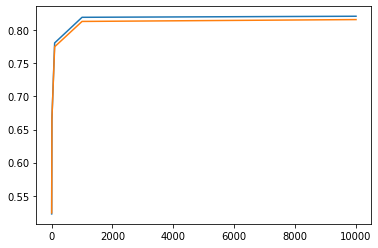

In [ ]:
print("tuning n_estimators ...")
x = [2, 10, 100, 1000, 10000]
y1, y2 = [], []
for i in x:
  rfc = RandomForestClassifier(n_estimators = i, max_depth=2,random_state=0)
  rfc.fit(X_train_vect, y_train)
  print("n_estimator = {}".format(i))
  strain = rfc.score(X_train_vect, y_train)
  stest = rfc.score(X_test, y_test)
  y1.append(strain)
  y2.append(stest)
  print("The training accuracy is {}".format(strain))
  print("The test accuracy is {}".format(stest))

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

tuning min_sample_split ...
min_sample_split = 0.01
The training accuracy is 0.78063122524901
The test accuracy is 0.7749109964398576
min_sample_split = 0.1
The training accuracy is 0.7793111724468978
The test accuracy is 0.7744709788391536
min_sample_split = 10
The training accuracy is 0.78083123324933
The test accuracy is 0.7750310012400496
min_sample_split = 100
The training accuracy is 0.780791231649266
The test accuracy is 0.7749909996399856
min_sample_split = 1000
The training accuracy is 0.7797911916476659
The test accuracy is 0.7749109964398576


<function matplotlib.pyplot.show>

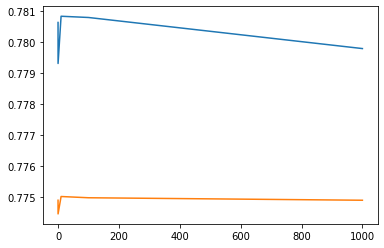

In [ ]:
print("tuning min_sample_split ...")
x = [0.01, 0.1, 10, 100, 1000]
y1, y2 = [], []
for i in x:
  rfc = RandomForestClassifier(min_samples_split = i, max_depth=2, random_state=0)
  rfc.fit(X_train_vect, y_train)
  print("min_sample_split = {}".format(i))
  strain = rfc.score(X_train_vect, y_train)
  stest = rfc.score(X_test, y_test)
  y1.append(strain)
  y2.append(stest)
  print("The training accuracy is {}".format(strain))
  print("The test accuracy is {}".format(stest))

plt.plot(x,y1)
plt.plot(x,y2)
plt.show
  

tuning max_depth ...
max_depth = 1
The training accuracy is 0.748829953198128
The test accuracy is 0.7429897195887836
max_depth = 2
The training accuracy is 0.78083123324933
The test accuracy is 0.7750310012400496
max_depth = 5
The training accuracy is 0.8239929597183887
The test accuracy is 0.813592543701748
max_depth = 10
The training accuracy is 0.859634385375415
The test accuracy is 0.8230329213168527
max_depth = 20
The training accuracy is 0.9329573182927318
The test accuracy is 0.8348333933357335


<function matplotlib.pyplot.show>

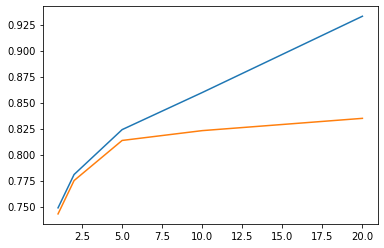

In [ ]:
print("tuning max_depth ...")
x = [1, 2, 5, 10, 20]
y1, y2 = [], []
for i in x:
  rfc = RandomForestClassifier(max_depth=i, random_state=0)
  rfc.fit(X_train_vect, y_train)
  print("max_depth = {}".format(i))
  strain = rfc.score(X_train_vect, y_train)
  stest = rfc.score(X_test, y_test)
  y1.append(strain)
  y2.append(stest)
  print("The training accuracy is {}".format(strain))
  print("The test accuracy is {}".format(stest))

plt.plot(x,y1)
plt.plot(x,y2)
plt.show

tuning max_features ...
max_features = 10
The training accuracy is 0.7408696347853914
The test accuracy is 0.7219488779551182
max_features = 200
The training accuracy is 0.7925117004680188
The test accuracy is 0.7911516460658427
max_features = 500
The training accuracy is 0.766430657226289
The test accuracy is 0.766990679627185
max_features = 1000
The training accuracy is 0.7392295691827673
The test accuracy is 0.7437897515900636


<function matplotlib.pyplot.show>

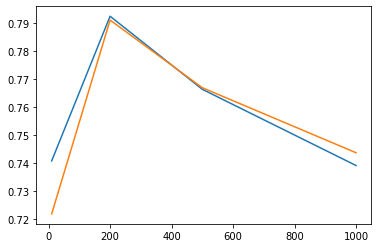

In [ ]:
print("tuning max_features ...")
x = [10, 200, 500, 1000]
y1, y2 = [], []
for i in x:
  rfc = RandomForestClassifier(max_features=i, max_depth = 2, random_state=0)
  rfc.fit(X_train_vect, y_train)
  print("max_features = {}".format(i))
  strain = rfc.score(X_train_vect, y_train)
  stest = rfc.score(X_test, y_test)
  y1.append(strain)
  y2.append(stest)
  print("The training accuracy is {}".format(strain))
  print("The test accuracy is {}".format(stest))

plt.plot(x,y1)
plt.plot(x,y2)
plt.show

In [ ]:
rfc = RandomForestClassifier(max_depth=20,n_estimators=1000,min_samples_split=10,max_features=200, random_state=0)
rfc.fit(X_train_vect, y_train)
print("The training accuracy is {}".format(rfc.score(X_train_vect, y_train)))
print("The test accuracy is {}".format(rfc.score(X_test, y_test)))

The training accuracy is 0.9198767950718029
The test accuracy is 0.8317532701308052


In [ ]:
print(rfc.predict([preprocess_sample_point(
    'Boring. This movie is terrible', vocabulary)]))

print(rfc.predict([preprocess_sample_point(
    'This movie was pretty good', vocabulary)]))

[-1]
[1]


### Question 5.2 Manual hyperparameter tuning

Tell us about your hyperparamter tuning in a few sentences! What was your approach? Which paramters did you try changing? Were you able to improve your accuracies? (no right answer, just tell us what you experiemented with!)

I started with the default parameters and the training accuracy was 0.7808 and the test accuracy was 0.7750.
Then I changed one parameter at a time. I tried values that were smaller than the default values and values that were greater than the default values and plot the result to determine which value to use. The results were shown in the graphs above. \\
Based on the graphs, I decided to use max_depth=20,n_estimators=1000,min_samples_split=10,max_features=200 and get 0.920 as the training accuracy and 0.832 as the test accuracy, which is close to the accuracies given the SVM.








## 6. [Optional] Tuning hyperparameters with GridSearchCV
In this **optional** section, we will explore how to exhaustively tune the hyperparameters of a new classifier using `sklearn's` [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Question 6.1 Creating an Adaboost classifier
In this section, we will be tuning the hyperparameters of an `adaboost` model. 

As its `sklearn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) mentions, this classifier "begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases." 

For this question, simply create an instance of the classifer and name it `abc`.

In [22]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)

### Question 6.2 Finding the best parameters
In order to use GridSearchCV, we need to provide it with a classifier (here, `abc`) and lists of different values for the hyperparameters we want to tune. GridSearchCV will run a fit using each possible parameter and get crossvalidation scores. 

For this question, use the GridSearchCV documentation to:
1. Create a dict of parameters to tune with their respective list of values
2. Create an instance of GridSearchCV with `abc` as the estimator and the following arguments: `cv=5, refit=False, verbose=3`
3. Print the resulting scores and determine which parameters are best!


In [ ]:
parameters = { 'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 1.0, 10.0],
 'algorithm': ['SAMME', 'SAMME.R']}
clf = GridSearchCV(abc, param_grid=parameters,cv=5, refit=False, verbose=3)
clf.fit(X_train_vect, y_train)
print(clf.best_params_)
print(classification_report(y_test, clf.predict(X_train_vect))) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=10, score=0.613, total=  41.9s
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.9s remaining:    0.0s


[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=10, score=0.617, total=  40.3s
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=10, score=0.615, total=  40.3s
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=10 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=10, score=0.609, total=  40.4s
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=10 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=10, score=0.613, total=  38.2s
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=50 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=50, score=0.613, total= 3.3min
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=50 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=50, score=0.617, total= 3.3min
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=50 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimators=50, score=0.615, total= 3.3min
[CV] algorithm=SAMME, learning_rate=0.01, n_estimators=50 ............
[CV]  algorithm=SAMME, learning_rate=0.01, n_estimat

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=10, score=nan, total=  16.6s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=10 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=10, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=10 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=10, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=10 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=10, score=nan, total=  16.3s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=10 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=10, score=nan, total=  15.5s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=50 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=50, score=nan, total=  16.3s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=50 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=50, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=50 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=50, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=50 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=50, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=50 ............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=50, score=nan, total=  15.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=100 ...........


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=100, score=nan, total=  16.5s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=100 ...........


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=100, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=100 ...........


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=100, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=100 ...........


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=100, score=nan, total=  16.4s
[CV] algorithm=SAMME, learning_rate=10.0, n_estimators=100 ...........


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)


[CV]  algorithm=SAMME, learning_rate=10.0, n_estimators=100, score=nan, total=  15.4s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=10 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=10, score=0.613, total=  40.4s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=10 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=10, score=0.648, total=  40.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=10 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=10, score=0.615, total=  40.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=10 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=10, score=0.609, total=  40.8s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=10 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=10, score=0.613, total=  38.0s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01

### Question 6.3 Final result with best parameters
Using the best parameters found in the previous question, reinstantiate an `adaboost` classifier, fit it to the train data, and print the the accuracy score on the test set. 

In [28]:
abc = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.0, n_estimators=100, random_state=0)
abc.fit(X_train_vect, y_train)
print(abc.score(X_test,y_test))



0.8244729789191567


## 7. Recap and conclusion
Congratulations on reaching the end of Assignment 2! We hope you enjoyed it. 

Here's a recap of tasks and concepts explored in this assignment:


1.   **Preprocessing**
*   Cleaning train data: removing punctuation and HTML tags
*   Basic feature engineering: vectorizing data, bag-of-words representation 
*   Using learned vocabulary to preprocess test data

Preprocessing and data representation are very important in Natural Language Processing (NLP) projects. For more advanced preprocessing techniques, we highly recommend checking online the concepts of **stemming**, **n-gramming**, **stopwords removal**!

2.   **Naive Bayes**
*   Naive Bayes: recap of theory
*   Implementing model from scratch

Find out more about Naive Bayes implementations in `sklearn`: [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), and more!

3.   **Support Vector Machine**
*   SVM: brief recap of theory and testing
*   First introduction to `sklearn`: using already implemented models to classify data

4.   **Random Forests**
*   Random Forests: brief recap of theory and testing
*   Introduction to hyperparameter tuning

The default parameters are not always good enough! Find out more about how to tune hyperparameters in `sklearn` [here](https://scikit-learn.org/stable/modules/grid_search.html) or do the optional section 6 of this assignment. 

5.   **Tuning Adaboost with GridSearchCV**
*   Adaboost: bried recap of theory and testing 
*   Tuning hyperparameters using GridSearchCV

## 8. Submission

Please submit this .ipynb to the appropriate folder on MyCourses.